### Extra Trees Classifier

This script demonstrates the training and evaluation of a classification model using an ExtraTreesClassifier. After loading the data, the dataset is split into training and validation sets. The model is first trained on the training data, and the validation set is used for a one-time single-run evaluation.

In addition to this, training and validation data are combined to perform cross-validation using StratifiedKFold, providing a more robust estimate of model performance. Finally, a separate test set is used to compute precision, recall, F1, and accuracy (both micro/macro and per class) in a single evaluation. The test set is never used during training or cross-validation, ensuring there is no data leakage.

**Model Used:**

An ExtraTreesClassifier is chosen due to its strong performance on tabular data, fast training speed, and robustness. It does not require feature scaling (normalization or standardization) and can handle imbalanced classes effectively when class_weight="balanced" is set.

**Metrics:**

Micro-averaged: Aggregates all classes to compute global precision, recall, and F1 (e.g., total true positives / total number of samples).

Macro-averaged: Calculates precision, recall, and F1 for each class individually and averages them, giving equal weight to all classes.

Per-class metrics: Show model performance for each class separately (precision, recall, F1-score, accuracy).

Cross-validation metrics: Averaged across all folds and also reported per class, providing both an overall and class-specific view of training performance. The clear separation of training/validation data and the test set ensures a realistic evaluation of the model's generalization ability.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report
)

##############################################################################
# 1) Load data, remove _time column if present
##############################################################################

def load_data_and_remove_time(file_path):
    """
    Loads the dataset from file_path, removes the '_time' column (if present),
    and returns X (features) and y (target variable).
    
    No feature engineering is applied to time-related data.
    """
    df = pd.read_csv(file_path)
    if '_time' in df.columns:
        df.drop(columns=['_time'], inplace=True)
        print("Spalte '_time' entfernt.")
    else:
        print("Keine '_time'-Spalte vorhanden. Keine Zeitfeatures berechnet.")
    
    # Wir nehmen an, die Label-Spalte heißt 'Label'
    X = df.drop(columns=['Label'])
    y = df['Label']
    
    print(f"Datensatz geladen: {df.shape[0]} Zeilen, {df.shape[1]+1} Spalten (inkl. 'Label').")
    return X, y

##############################################################################
# 2) Split into Train/Val/Test
##############################################################################

def split_data(X, y, test_size=0.15, val_size=0.1765, random_state=42):
    """
     Performs a stratified shuffle split into Train, Validation, and Test sets:
    
    - First, test_size (e.g., 15%) is split off => (TrainVal, Test)
    - Then, a portion val_size (e.g., 17.65%) is split from (TrainVal) for validation.
    - Results in approximately 70% Train, 15% Validation, and 15% Test (default example).
    """
    from sklearn.model_selection import train_test_split
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=val_size,
        random_state=random_state,
        stratify=y_train_val
    )
    
    print("=== Daten-Split ===")
    print(f"Train: {X_train.shape},  Val: {X_val.shape},  Test: {X_test.shape}")
    return X_train, X_val, X_test, y_train, y_val, y_test

##############################################################################
# 3) Training
##############################################################################

def train_model(X_train, y_train):
    """
    Trains an ExtraTreesClassifier (robust to imbalanced data,
    no normalization required).
    """
    model = ExtraTreesClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",
        class_weight="balanced",
        random_state=100
    )
    model.fit(X_train, y_train)
    print("Modell erfolgreich trainiert (ExtraTrees).")
    return model

##############################################################################
# 4) Single-Run Evaluation (Val or Test)
##############################################################################

def evaluate_single_run(model, X_eval, y_eval, title="Single Run"):
    """
    Performs a single prediction and computes:
    - Micro Accuracy, Precision, Recall, F1
    - Macro Precision, Recall, F1
    - Per-Class Accuracy, Precision, Recall, F1
    Prints all metrics and returns a dictionary with the results.
    """
    y_pred = model.predict(X_eval)
    
    micro_acc  = accuracy_score(y_eval, y_pred)
    micro_prec = precision_score(y_eval, y_pred, average='micro', zero_division=0)
    micro_rec  = recall_score(y_eval, y_pred, average='micro', zero_division=0)
    micro_f1   = f1_score(y_eval, y_pred, average='micro', zero_division=0)
    
    macro_prec = precision_score(y_eval, y_pred, average='macro', zero_division=0)
    macro_rec  = recall_score(y_eval, y_pred, average='macro', zero_division=0)
    macro_f1   = f1_score(y_eval, y_pred, average='macro', zero_division=0)
    
    # Per-Class
    cls_report = classification_report(y_eval, y_pred, zero_division=0, output_dict=True)
    
    print(f"\n=== {title} ===")
    print(f"MICRO:  Acc={micro_acc:.4f},  Prec={micro_prec:.4f},  Rec={micro_rec:.4f},  F1={micro_f1:.4f}")
    print(f"MACRO:          Prec={macro_prec:.4f},  Rec={macro_rec:.4f},  F1={macro_f1:.4f}")
    print("\n--- Per-Class ---")
    
    for cls_str, metrics in cls_report.items():
        if cls_str in ["accuracy", "macro avg", "weighted avg"]:
            continue
        # Kleine Genauigkeit pro Klasse
        true_cls = (y_eval == int(cls_str))
        pred_cls = (y_pred == int(cls_str))
        acc_c    = accuracy_score(y_eval[true_cls], y_pred[true_cls]) if np.any(true_cls) else 0.0
        
        print(f"Klasse {cls_str}: "
              f"Acc={acc_c:.4f}, "
              f"Prec={metrics['precision']:.4f}, "
              f"Rec={metrics['recall']:.4f}, "
              f"F1={metrics['f1-score']:.4f}")
    
    return {
        "micro_acc": micro_acc,
        "micro_prec": micro_prec,
        "micro_rec": micro_rec,
        "micro_f1": micro_f1,
        "macro_prec": macro_prec,
        "macro_rec": macro_rec,
        "macro_f1": macro_f1,
        "cls_report": cls_report
    }

##############################################################################
# 5) Cross-Validation with StratifiedKFold (Train+Val)
##############################################################################

def cross_validate_model(model, X_cv, y_cv, n_splits=5):
    """
    Performs StratifiedKFold cross-validation on the given data.
    - Micro/Macro + Per-Class metrics are averaged across all folds.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    from collections import defaultdict
    import numpy as np
    
    # Sammler für micro/macro
    micro_accs  = []
    micro_precs = []
    micro_recs  = []
    micro_f1s   = []
    
    macro_precs = []
    macro_recs  = []
    macro_f1s   = []
    macro_accs  = []
    
    unique_classes = sorted(np.unique(y_cv))
    
    # Speichert pro Klasse Listen von [acc, prec, rec, f1]
    per_class_dict = defaultdict(lambda: {
        "acc": [], "prec": [], "rec": [], "f1": []
    })
    
    for train_idx, val_idx in skf.split(X_cv, y_cv):
        X_train_fold = X_cv.iloc[train_idx]
        y_train_fold = y_cv.iloc[train_idx]
        X_val_fold   = X_cv.iloc[val_idx]
        y_val_fold   = y_cv.iloc[val_idx]
        
        # Fitte das Modell auf den Fold-Train-Daten
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        
        # Micro
        mi_acc  = accuracy_score(y_val_fold, y_pred_fold)
        mi_prec = precision_score(y_val_fold, y_pred_fold, average='micro', zero_division=0)
        mi_rec  = recall_score(y_val_fold, y_pred_fold, average='micro', zero_division=0)
        mi_f1   = f1_score(y_val_fold, y_pred_fold, average='micro', zero_division=0)
        
        micro_accs.append(mi_acc)
        micro_precs.append(mi_prec)
        micro_recs.append(mi_rec)
        micro_f1s.append(mi_f1)
        
        # Macro
        ma_prec = precision_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
        ma_rec  = recall_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
        ma_f1   = f1_score(y_val_fold, y_pred_fold, average='macro', zero_division=0)
        
        # Per-Class
        cls_report_fold = classification_report(y_val_fold, y_pred_fold, output_dict=True, zero_division=0)
        
        # Finde pro Klasse Acc, Prec, Rec, F1
        fold_accs = []
        for cls_ in unique_classes:
            cls_str = str(cls_)
            if cls_str in cls_report_fold:
                prec_c = cls_report_fold[cls_str]['precision']
                rec_c  = cls_report_fold[cls_str]['recall']
                f1_c   = cls_report_fold[cls_str]['f1-score']
            else:
                prec_c, rec_c, f1_c = 0.0, 0.0, 0.0
            
            mask_cls = (y_val_fold == cls_)
            acc_c    = accuracy_score(y_val_fold[mask_cls], y_pred_fold[mask_cls]) if np.any(mask_cls) else 0.0
            
            per_class_dict[cls_]["acc"].append(acc_c)
            per_class_dict[cls_]["prec"].append(prec_c)
            per_class_dict[cls_]["rec"].append(rec_c)
            per_class_dict[cls_]["f1"].append(f1_c)
            
            fold_accs.append(acc_c)
        
        # Macro-Acc = mean der Acc pro Klasse
        ma_acc = np.mean(fold_accs)
        
        macro_precs.append(ma_prec)
        macro_recs.append(ma_rec)
        macro_f1s.append(ma_f1)
        macro_accs.append(ma_acc)
    
    # Gemittelte Werte
    avg_micro = {
        "acc":  np.mean(micro_accs),
        "prec": np.mean(micro_precs),
        "rec":  np.mean(micro_recs),
        "f1":   np.mean(micro_f1s),
    }
    avg_macro = {
        "acc":  np.mean(macro_accs),
        "prec": np.mean(macro_precs),
        "rec":  np.mean(macro_recs),
        "f1":   np.mean(macro_f1s),
    }
    
    # Per-Class gemittelt
    avg_per_class = {}
    for cls_ in unique_classes:
        avg_per_class[cls_] = {
            "Accuracy":  np.mean(per_class_dict[cls_]["acc"]),
            "Precision": np.mean(per_class_dict[cls_]["prec"]),
            "Recall":    np.mean(per_class_dict[cls_]["rec"]),
            "F1-Score":  np.mean(per_class_dict[cls_]["f1"])
        }
    
    print("\n=== Cross-Validation (StratifiedKFold) ===")
    print(f"MICRO:  Acc={avg_micro['acc']:.4f},  Prec={avg_micro['prec']:.4f},  Rec={avg_micro['rec']:.4f},  F1={avg_micro['f1']:.4f}")
    print(f"MACRO:  Acc={avg_macro['acc']:.4f},  Prec={avg_macro['prec']:.4f},  Rec={avg_macro['rec']:.4f},  F1={avg_macro['f1']:.4f}")
    print("\n--- Per-Class (gemittelt über alle Folds) ---")
    for cls_ in unique_classes:
        vals = avg_per_class[cls_]
        print(f"Klasse {cls_}: Acc={vals['Accuracy']:.4f}, "
              f"Prec={vals['Precision']:.4f}, "
              f"Rec={vals['Recall']:.4f}, "
              f"F1={vals['F1-Score']:.4f}")
    
    return {
        "micro": avg_micro,
        "macro": avg_macro,
        "per_class": avg_per_class
    }

##############################################################################
# 6) Main script
##############################################################################

if __name__ == "__main__":
    file_path = "data_with_timestamps_cleaned.csv"  
    
    # 1) Load data
    X, y = load_data_and_remove_time(file_path)
    
    # 2) Split into Train/Val/Test
    # Standard: 15% Test, 17.65% Val of rest -> ~70%/15%/15%
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y, test_size=0.15, val_size=0.1765, random_state=42)
    
    # 3) Modell training
    model = train_model(X_train, y_train)
    
    # 4) Single-Run: Validation
    val_results = evaluate_single_run(model, X_val, y_val, title="Validation - Single Run")
    
    # 5) Cross-Validation (Train+Val)
    import pandas as pd
    X_cv = pd.concat([X_train, X_val], axis=0)
    y_cv = pd.concat([y_train, y_val], axis=0)
    
    cv_results = cross_validate_model(model, X_cv, y_cv, n_splits=5)
    
    # 6) Single-Run: Test
    test_results = evaluate_single_run(model, X_test, y_test, title="Final Test - Single Run")


Spalte '_time' entfernt.
Datensatz geladen: 968717 Zeilen, 44 Spalten (inkl. 'Label').
=== Daten-Split ===
Train: (678077, 42),  Val: (145332, 42),  Test: (145308, 42)
Modell erfolgreich trainiert (ExtraTrees).

=== Validation - Single Run ===
MICRO:  Acc=0.9729,  Prec=0.9729,  Rec=0.9729,  F1=0.9729
MACRO:          Prec=0.9366,  Rec=0.9561,  F1=0.9461

--- Per-Class ---
Klasse 0: Acc=0.9142, Prec=0.9029, Rec=0.9142, F1=0.9085
Klasse 1: Acc=0.9216, Prec=0.9314, Rec=0.9216, F1=0.9265
Klasse 2: Acc=0.9647, Prec=0.9096, Rec=0.9647, F1=0.9364
Klasse 3: Acc=0.9524, Prec=0.9352, Rec=0.9524, F1=0.9437
Klasse 4: Acc=0.9854, Prec=0.9970, Rec=0.9854, F1=0.9912
Klasse 5: Acc=0.9880, Prec=0.9317, Rec=0.9880, F1=0.9591
Klasse 6: Acc=0.9666, Prec=0.9482, Rec=0.9666, F1=0.9573

=== Cross-Validation (StratifiedKFold) ===
MICRO:  Acc=0.9730,  Prec=0.9730,  Rec=0.9730,  F1=0.9730
MACRO:  Acc=0.9561,  Prec=0.9372,  Rec=0.9561,  F1=0.9464

--- Per-Class (gemittelt über alle Folds) ---
Klasse 0: Acc=0.9132

### Brief Summary

Using an ExtraTrees classifier (n_estimators=300, max_depth=15, class_weight="balanced"), we consistently achieve around 97% Micro-F1 on training, validation, and test sets—despite highly imbalanced classes and without incorporating time-based features, normalization, or SMOTE. The model clearly outperforms other approaches (e.g., standard RandomForest), primarily because:

- Class-weight balancing in ExtraTrees ensures that even rare classes are well detected.

- Extremely randomized splits increase the diversity among decision trees, reducing overfitting.

- Large data volume (almost 1 million rows) provides sufficient examples for each class.

- No scaling or SMOTE needed: Tree-based models apply thresholds directly on raw feature values, and SMOTE can actually harm performance on large datasets.

- No time features: Avoids potential data leakage and unnecessary complexity.

### Outlook

- The results are consistent across validation, test sets, and cross-validation—indicating strong generalizability.

- Greater interpretability could be achieved through SHAP or permutation importance to identify the most influential features.

- Fine-tuning additional hyperparameters (e.g., deeper grid search) could yield marginal improvements.

- With highly imbalanced data, it's still important to regularly inspect confusion matrices to avoid disadvantaging individual classes.

- Overall, this demonstrates that a large, well-structured dataset and a robust, highly diversified classifier like ExtraTrees can deliver excellent results—even without extra techniques like time features, scaling, or SMOTE.

### Permutation Feature Importance

#### Why Use Permutation Feature Importance?

By permuting a feature in the dataset, its relationship with the target is broken, and we can measure how much the model's performance (e.g., Accuracy, F1) drops as a result.
The greater the performance drop when a feature is permuted, the more important that feature was to the model.

**Advantage over model-internal importances (e.g., feature_importances_ in tree models):**

Permutation importance effectively measures how much the prediction quality degrades when a feature is made "useless," offering a more realistic view of its impact.

=== Starte Permutations-Feature-Importance ===

Permutation Importance (Sortierung nach Mean):

AggHoeheIst                MeanImp=0.08324  +/- 0.00032
VMesserIst                 MeanImp=0.07742  +/- 0.00048
SAUAbstandIst              MeanImp=0.02224  +/- 0.00024
Blocklaenge120m            MeanImp=0.01397  +/- 0.00031
HTB_TemperaturIst          MeanImp=0.01289  +/- 0.00029
BSVE_LaengeSoll            MeanImp=0.01223  +/- 0.00024
DrwHoeheIst                MeanImp=0.01169  +/- 0.00019
DrwHoeheOffsetAutomatik    MeanImp=0.00735  +/- 0.00012
HTB_StromIst               MeanImp=0.00664  +/- 0.00020
BetriebsartBSVE            MeanImp=0.00494  +/- 0.00026
BetriebsartManuell         MeanImp=0.00448  +/- 0.00019
VWicklerIst                MeanImp=0.00440  +/- 0.00013
HTBVIst                    MeanImp=0.00394  +/- 0.00022
HTB_VIst                   MeanImp=0.00332  +/- 0.00014
Halbautomat_StueckzahlIst  MeanImp=0.00306  +/- 0.00010
BSVE_StueckzahlIst         MeanImp=0.00303  +/- 0.00016
BSR_Stue

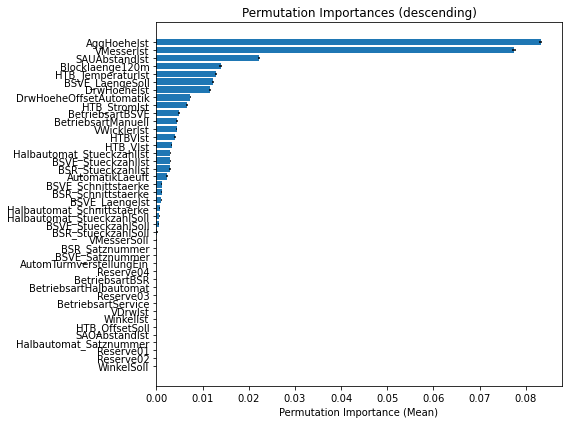


Fertig mit Permutations-Feature-Importance.



In [ ]:
# ===========================================
# Permutation Importance Skript
# ===========================================
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def permutation_importance_analysis(model, X_val, y_val, n_repeats=10):
    """
    Führt eine Permutations-Feature-Importance für 'model' durch, 
    basierend auf (X_val, y_val). 
    n_repeats = wie oft wird permutiert, um Varianz zu verringern.
    Gibt ein Plot der wichtigsten Features aus und druckt die Werte.
    """
    print("=== Starte Permutations-Feature-Importance ===")
    
    # 1) Permutation-Results
    perm = permutation_importance(
        estimator=model,
        X=X_val,
        y=y_val,
        n_repeats=n_repeats,
        random_state=42,  
        scoring='f1_micro' 
    )
    
    # 2) Sort (descending)
    sorted_idx = perm.importances_mean.argsort()[::-1]
    
    # 3) Print importance
    print("\nPermutation Importance (Sortierung nach Mean):\n")
    for idx in sorted_idx:
        feat_name = X_val.columns[idx]
        mean_imp = perm.importances_mean[idx]
        std_imp  = perm.importances_std[idx]
        print(f"{feat_name:25s}  MeanImp={mean_imp:.5f}  +/- {std_imp:.5f}")
    
    # 4) Visualization
    fig, ax = plt.subplots(figsize=(8, 6))
    feat_names_sorted = [X_val.columns[i] for i in sorted_idx]
    mean_values = perm.importances_mean[sorted_idx]
    ax.barh(feat_names_sorted, mean_values, xerr=perm.importances_std[sorted_idx], align='center')
    ax.set_xlabel("Permutation Importance (Mean)")
    ax.set_title("Permutation Importances (descending)")
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nFertig mit Permutations-Feature-Importance.\n")


permutation_importance_analysis(model, X_val, y_val, n_repeats=10)
